### <div class="label label-info">CLAUDIO SCALZO</div>
# ASI Challenge Exercise
### Naive Bayes Classification and Bayesian Linear Regression on the <tt>Fashion-MNIST</tt> and <tt>CIFAR-10</tt> datasets

<div class='alert alert-info'>
<div class='label label-info'>DESCRIPTION</div>
<br>
This notebook presents the "from-scratch" implementations of the <b>Naive Bayes Classification</b> and the <b>Bayesian Linear Regression</b>, applied to the <a href="https://www.kaggle.com/zalando-research/fashionmnist/data"><tt>Fashion-MNIST</tt></a> and <a href="https://www.cs.toronto.edu/~kriz/cifar.html"><tt>CIFAR-10</tt></a> datasets.<br>
<br>
<div class='label label-info'>INSTRUCTIONS TO RUN THE NOTEBOOK</div>
<br>
To be able to run the notebook the only thing to ensure is that the datasets are in the correct directories. The following structure is the correct one:
<code>
- asi_challenge_claudio_scalzo.ipynb
- datasets/
    - Fashion-MNIST/
        - fashion-mnist_train.csv
        - fashion-mnist_test.csv
    - CIFAR-10/
        - data_batch_1
        - data_batch_2
        - data_batch_3
        - data_batch_4
        - data_batch_5
        - test_batch
</code>
<br>
<div class='label label-info'>COLORS</div>
<br>
For the sake of readability, the notebook will follow a color convention:
<br>
<ul>
    <li>All the cells related to the <tt>Fashion-MNIST</tt> dataset will be in green and labeled with: <div class="label label-success">FASHION-MNIST</div></li>
    <li>All the cells related to the <tt>CIFAR-10</tt> dataset will be in yellow and labeled with: <div class="label label-warning">CIFAR-10</div></li>
    <li>All the blue cells are generic comments and the answers to the exercise questions are marked with: <div class="label label-danger">ANSWER</div> or <div class="label label-info">TASK</div></li>
</ul>
<br>
<div class='label label-info'>SECTIONS</div>
<br>
The sections numbering will follow exactly the one provided in the requirements PDF.
</div>

In [1]:
### LIBRARIES IMPORT

# Data structures
import numpy as np
import pandas as pd
from numpy.linalg import inv, solve

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Utilities
import math as math
from time import time, sleep
import pickle
import itertools

# SciPy, scikit-learn
from scipy.stats import skew, probplot, multivariate_normal
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix

# Warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Datasets loading

<div class='alert alert-info'>
<div class='label label-info'>TASK</div><br>
<b><i>1. Download the <tt>Fashion-MNIST</tt> and <tt>CIFAR-10</tt> datasets and import them.<br></i></b>
<br>
The first step consists in the datasets import. This process will be split in two parts, one for the <tt>Fashion-MNIST</tt> dataset and another one for the <tt>CIFAR-10</tt> dataset. While in the first case it will be very easy (being the dataset saved in <b>csv</b> files), in the seconds case the process will be longer, because the CIFAR datasets are saved in <b>binary</b> files.
</div>

### <div class="label label-success">FASHION-MNIST</div>

<div class='alert alert-success'>
Let's define the datasets location and load them in two Pandas DataFrame: <tt>mnistTrain</tt> and <tt>mnistTest</tt>.
</div>

In [2]:
# DIRECTORY AND CONSTANTS DEFINITION
mnistPath = "./datasets/Fashion-MNIST/"
height = 28
width = 28

# FILEPATHS DEFINITION
mnistTrainFile = mnistPath + "fashion-mnist_train.csv"
mnistTestFile = mnistPath + "fashion-mnist_test.csv"

# LOAD THE MNIST AND CIFAR TRAINSET AND DATASET
mnistTrain = pd.read_csv(mnistTrainFile)
mnistTest = pd.read_csv(mnistTestFile)

<div class='alert alert-success'>
Now we can show some example of the loaded data:
</div>

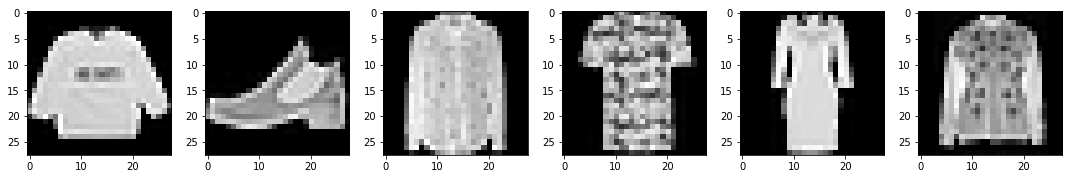

In [3]:
# SHOW SOME SAMPLES
plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(1,6,i+1)
    image = mnistTrain.drop(columns=["label"]).loc[i].values.reshape((height, width))
    plt.imshow(image, cmap="gray")
plt.tight_layout()
plt.show()

### <div class="label label-warning">CIFAR-10</div>

<div class='alert alert-warning'>
First of all, we have to declare the path of the <tt>CIFAR-10</tt> datasets and some useful values:
</div>

In [4]:
# DIRECTORY AND CONSTANTS DEFINITION
cifarPath = "./datasets/CIFAR-10/"
trainfiles = 5
height = 32
width = 32
channels = 3
pixels = height * width * channels
chpix = height * width

<div class='alert alert-warning'>
Now, let's define a function to load a single binary file which contains a certain number of images:
</div>

In [5]:
# FUNCTION TO LOAD A SINGLE TRAINFILE
def loadImages(filename):
    
    # Load binary file
    file = open(filename, "rb")
    
    # Unpickle
    data = pickle.load(file, encoding="bytes")
    
    # Get raw images and raw classes
    rawImages = data[b'data']
    rawClasses = data[b'labels']
    
    return np.array(rawImages, dtype=int), np.array(rawClasses, dtype=int)

<div class='alert alert-warning'>
Now it's time to use the previous function to load all the five <b>trainsets</b> in our directory: they will be merged in a unique Pandas DataFrame named <tt>cifarTrain</tt>.
</div>

In [6]:
# ALLOCATE AN EMPTY ARRAY (width of number of pixels + one for the class label)
images = np.empty(shape=(0, pixels + 1), dtype=int)

# LOAD ALL THE TRAINFILES
for i in range(trainfiles):
    
    # Load the images and classes for the "i"th trainfile
    newImages, newClasses = loadImages(filename = cifarPath + "data_batch_" + str(i + 1))
    
    # Create the new batch (concatenating images and classes)
    newBatch = np.concatenate((np.asmatrix(newClasses).T, newImages), axis=1)
    
    # Concatenate the new batch with the previous ones
    images = np.concatenate((images, newBatch), axis=0)

# CREATE THE TRAIN DATAFRAME
attributes = [("pixel" + str(i) + "_" + str(c)) for c in ["r", "g", "b"] for i in range(height * width)]
cifarTrain = pd.DataFrame(images, columns = ["label"] + attributes)

<div class='alert alert-warning'>
The <tt>cifarTrain</tt> has been imported, now let's do the same for the file containing the <b>testset</b>: also in this case, it will be saved in a dataframe, <tt>cifarTest</tt>.
</div>

In [7]:
# LOAD THE IMAGES AND CLASSES
newImages, newClasses = loadImages(filename = cifarPath + "test_batch")

# CREATE THE IMAGES ARRAY (concatenating images and classes)
images = np.concatenate((np.asmatrix(newClasses).T, newImages), axis=1)

# CREATE THE TEST DATAFRAME
attributes = [("pixel" + str(i) + "_" + str(c)) for i in range(height * width) for c in ["r", "g", "b"]]
cifarTest = pd.DataFrame(images, columns = ["label"] + attributes)

<div class='alert alert-warning'>
Now we can show some example of the loaded data:
</div>

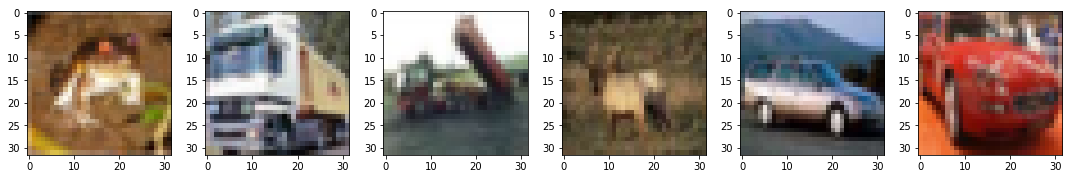

In [8]:
# SHOW SOME SAMPLES
plt.figure(figsize=(15,10))
for i in range(0,6):
    plt.subplot(1,6,i+1)
    imageR = cifarTrain.iloc[i, 1 : chpix+1].values.reshape((height,width))
    imageG = cifarTrain.iloc[i, chpix+1 : 2*chpix+1].values.reshape((height,width))
    imageB = cifarTrain.iloc[i, 2*chpix+1 : 3*chpix+1].values.reshape((height,width))
    image = np.dstack((imageR, imageG, imageB))
    plt.imshow(image)
plt.tight_layout()
plt.show()

<div class='alert alert-info'>
Everything is loaded! We can start analyzing our data.
</div>

# 2. Descriptive statistics

### 2.1 Data description

<div class='alert alert-info'>
The first step is to investigate data. It is a fundamental section, where we will learn about our data. Initially we show and plot really simple statistics: they are useful to introduce us, to understand what we are dealing with.
</div>

### <div class="label label-success">FASHION-MNIST</div>

In [9]:
# PRINT TO DESCRIBE THE TRAIN AND THE TEST
print("[TRAINSET]")
print("Number of rows:", mnistTrain.shape[0])
print("Attributes:", mnistTrain.drop(columns=['label']).shape[1], "(without considering the label)")

print("\n[TESTSET]")
print("Number of rows:", mnistTest.shape[0])
print("Attributes:", mnistTest.drop(columns=['label']).shape[1], "(without considering the label)")

print("\nExample:")
display(mnistTrain.head(5))

[TRAINSET]
Number of rows: 60000
Attributes: 784 (without considering the label)

[TESTSET]
Number of rows: 10000
Attributes: 784 (without considering the label)

Example:


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class='alert alert-success'>
The number of rows is <b>60000</b>, while the number of columns is <b>785</b> (784 attributes + 1 label). But what does they mean?<br>
<br>
<list>
    <li>Each <b>row</b> represents a picture.</li>
    <li>Each <b>column</b> represents a pixel.</li>
    <li>So, the <b>value</b> of a row <i>"r"</i> in a given column <i>"c"</i> represents the brightness (from 0 to 255) of a given pixel <i>"c"</i> in a given picture <i>"r"</i>.</li>
</list><br>
In the testset we find the same situation but with a smaller row dimension: <b>10000</b>. The number of columns is, of course, the same: <b>785</b> (784 attributes + 1 label).<br>
</div>

### <div class="label label-warning">CIFAR-10</div>

In [10]:
# PRINT TO DESCRIBE THE TRAIN
print("[TRAINSET]")
print("Number of rows:", cifarTrain.shape[0])
print("Attributes:", cifarTrain.drop(columns=['label']).shape[1], "(without considering the label)")

print("\n[TESTSET]")
print("Number of rows:", cifarTest.shape[0])
print("Attributes:", cifarTest.drop(columns=['label']).shape[1], "(without considering the label)")

print("\nExample:")
display(cifarTrain.head(5))

[TRAINSET]
Number of rows: 50000
Attributes: 3072 (without considering the label)

[TESTSET]
Number of rows: 10000
Attributes: 3072 (without considering the label)

Example:


,label,pixel0_r,pixel1_r,pixel2_r,pixel3_r,pixel4_r,pixel5_r,pixel6_r,pixel7_r,pixel8_r,...,pixel1014_b,pixel1015_b,pixel1016_b,pixel1017_b,pixel1018_b,pixel1019_b,pixel1020_b,pixel1021_b,pixel1022_b,pixel1023_b
0,6,59,43,50,68,98,119,139,145,149,...,59,58,65,59,46,57,104,140,84,72
1,9,154,126,105,102,125,155,172,180,142,...,22,42,67,101,122,133,136,139,142,144
2,9,255,253,253,253,253,253,253,253,253,...,78,83,80,69,66,72,79,83,83,84
3,4,28,37,38,42,44,40,40,24,32,...,53,39,59,42,44,48,38,28,37,46
4,1,170,168,177,183,181,177,181,184,189,...,92,88,85,82,83,79,78,82,78,80


<div class='alert alert-warning'>
The number of rows is <b>50000</b>, because we merged 5 files of 10000 rows (images) each. The number of columns is instead <b>3073</b> (3072 attributes + the label): why this number? Because each picture was a 32x32 pixels, with 3 channels (RGB), so each picture has 3072 pixels.<br>
<br>
The number of rows in the testset is smaller: <b>10000</b>.<br>
</div>

### 2.2 Data distribution analysis

<div class='alert alert-info'>
Now is time to analyze the distribution of our data. In this section I'm going to analyze the distribution of <b>both</b> the trainset and the testset, so I'll create the <tt>all</tt> variables.
</div>

In [11]:
# CREATE THE 'ALL' DATAFRAMES
mnistAll = pd.concat((mnistTrain, mnistTest)).reset_index(drop=True)
cifarAll = pd.concat((cifarTrain, cifarTest)).reset_index(drop=True)

### <div class="label label-success">FASHION-MNIST</div> <div class="label label-warning">CIFAR-10</div>

In [12]:
# TAKE DISTRIBUTION
mnistDistribution = mnistAll["label"].value_counts()
cifarDistribution = cifarAll["label"].value_counts()

# TAKE CLASSES AND FREQUENCIES
mnistClasses = np.array(mnistDistribution.index)
mnistFrequencies = np.array(mnistDistribution.values)

cifarClasses = np.array(cifarDistribution.index)
cifarFrequencies = np.array(cifarDistribution.values)

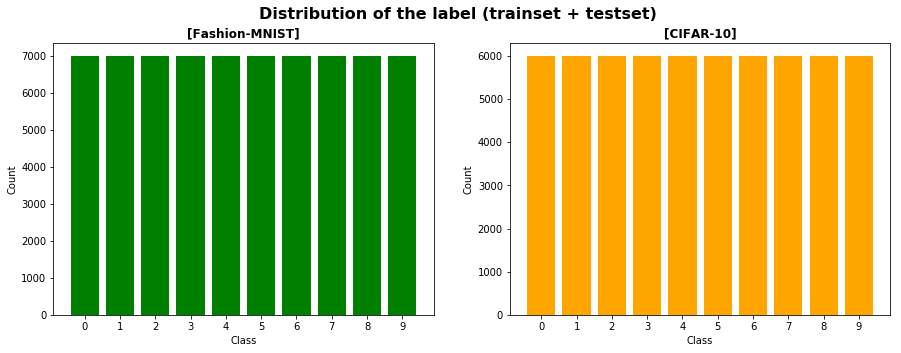

In [13]:
# PLOT THE DISTRIBUTION OF THE TARGET VARIABLE
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.bar(mnistClasses, mnistFrequencies, align="center", color="green")
plt.xticks(list(range(np.min(mnistClasses), np.max(mnistClasses)+1)))
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("[Fashion-MNIST]", weight="semibold");

plt.subplot(1,2,2)
plt.bar(cifarClasses, cifarFrequencies, align="center", color="orange")
plt.xticks(list(range(np.min(mnistClasses), np.max(mnistClasses)+1)))
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("[CIFAR-10]", weight="semibold");

plt.suptitle("Distribution of the label (trainset + testset)", fontsize=16, weight="bold")
plt.show()

<div class='alert alert-info'>
<div class='label label-danger'>QUESTION</div><br>
<i><b>Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.</b></i><br>
<br>
<div class='label label-danger'>ANSWER</div><br>
<b>- The dimensionality</b><br>
First of all, the dimensionality is very high. As previously said, each column represents a pixel of the image! So, even a very small picture has a lot of features. A big dimensionality like this (784 attributes on the <tt>Fashion-MNIST</tt> and 3072 attributes on the <tt>CIFAR-10</tt>) can usually represent an issue, generally known as "curse of dimensionality" (<a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality">source</a>).<br>
<br>
However, the Naive Bayes classifier is usually <b>suited</b> when dealing with high-dimensional datasets: indeed, thanks to its simplicity and thanks also to its Naive assumptions can perform well when data dimensionality is really really high.
<br><br>
In our case, the high dimensionality is an issue especially for the regressor.
The Bayesian Linear Regression algorithm, indeed, has to find the weights (and find the regression line) basing its analysis on a big set of dimensions, which is of course harder (and computationally heavier because of the big matrices in the products).<br>
<br>
<b>- The distribution</b><br>
The distribution is <b>uniform</b>: each class has the same amount of images in the dataset. We'll use this fact to compute the prior probabilities in the Naive Bayes Classifier: being each prior the same for each class, the model will <b>not</b> be biased towards some classes, because the posterior computation will be equally influenced by this factor for each class.<br>
</div>

<div class='alert alert-info'>
Before starting the new section, let's define some functions to graphically plot the confusion matrix, the errorplot and the scatter plot. This function will be useful to show the classifier and the regressor performance in the two datasets.
</div>

In [14]:
# FUNCTION TO PLOT THE REQUIRED CONFUSION MATRICES
def plotConfusionMatrix(cm1, cm2, classes1, classes2, normalize = False):

    def plotCM(cm, classes, cmap, title):
        sns.heatmap(cm, cmap=cmap, annot=True, fmt="d", cbar=False)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title(title)
    
    plt.figure(figsize=(16,7))
    plt.subplot(1,2,1)
    plotCM(cm1, classes1, "Greens", "[Fashion-MNIST]")
    plt.subplot(1,2,2)
    plotCM(cm2, classes2, "Oranges", "[CIFAR-10]")
    
    plt.subplots_adjust(wspace=0.4)
    plt.show()
    print()


# FUNCTION TO PLOT THE REQUIRED SCATTER PLOTS
def plotScatterPlot(raw1, raw2, corr1, corr2):
    
    def plotSP(raw, corr, color, title):
        plt.title(title)
        plt.xticks(np.arange(0,10))
        plt.yticks(np.arange(0,10))
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.grid(axis='x', linestyle=':')
        plt.scatter(raw, corr, color=color)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plotSP(raw1, corr1, "green", "[Fashion-MNIST]")
    plt.subplot(1,2,2)
    plotSP(raw2, corr2, "orange", "[CIFAR-10]")
    plt.suptitle("Scatter plot of true raw predictions versus predicted ones", weight="semibold", fontsize=14)
    plt.show()
    print()


# FUNCTION TO PLOT THE REQUIRED ERROR PLOTS
def plotErrorPlot(pred1, pred2, var1, var2):
    
    def plotEP(pred, var, color, title):
        plt.errorbar(np.arange(0,30), pred[:30], var[:30], ls="None",
                     color=color, marker=".", markerfacecolor="black")
        plt.ylabel('Predictive variance')
        plt.xlabel('Sample of dataset')
        plt.title(title)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plotEP(pred1, var1, "green", "[Fashion-MNIST]")
    plt.subplot(1,2,2)
    plotEP(pred2, var2, "orange", "[CIFAR-10]")
    plt.suptitle("Predicted variances on a subset of the predicted data", weight="semibold", fontsize=14)
    plt.show()
    print()

<div class='alert alert-info'>
Moreover, to facilitate each model's work, we can normalize the values of our datasets (except for the class label) dividing each value by 255. Let's do it:
</div>

In [15]:
def normalize(dataset):
    return dataset.apply(lambda col: col.divide(255) if(col.name != "label") else col)

# NORMALIZE MNIST
mnistTrainNorm = normalize(mnistTrain)
mnistTestNorm = normalize(mnistTest)

# NORMALIZE CIFAR
cifarTrainNorm = normalize(cifarTrain)
cifarTestNorm = normalize(cifarTest)

# PRINT AN EXAMPLE
print("Example of the normalized MNIST trainset:")
display(mnistTrainNorm.head(5))

Example of the normalized MNIST trainset:


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [16]:
# SPLIT THE DATASETS IN 'X' AND 'y'
# Fashion-MNIST
mnistTrain = mnistTrainNorm.drop(columns=['label']).values
mnistTarget = mnistTrainNorm['label'].values
mnistTest = mnistTestNorm.drop(columns=['label']).values
mnistCorrect = mnistTestNorm['label'].values

# CIFAR-10
cifarTrain = cifarTrainNorm.drop(columns=['label']).values
cifarTarget = cifarTrainNorm['label'].values
cifarTest = cifarTestNorm.drop(columns=['label']).values
cifarCorrect = cifarTestNorm['label'].values

<div class='alert alert-info'>
Now we're ready to start the classification.
</div>

# 3. Classification

<div class='alert alert-info'>
<div class='label label-info'>TASK</div><br>
<b><i>a) Implement the Naive Bayes Classifier.<br></i></b>
<br>
The <b>Naive Bayes Classifier</b> is for sure the most basic and simple algorithm belonging to the probabilistic classifiers family. It puts its roots into the Bayes theorem, specifically the <b>Naive</b> version, which considers independent all the features. This assumption has of course two main aspects: the first one is to heavily simplify the computation, the other one is of course to be too "naive", not respecting most of the times the real dependence among features.<br>
<br>
$$
P(t_{new}=k \mid \mathbf{X}, \mathbf{t}, \mathbf{x_{new}}) = 
    \dfrac{P(\mathbf{x_{new}} \mid t_{new}=k, \mathbf{X}, \mathbf{t}) \space P(t_{new}=k)}
          {\sum_{j=0}^{K-1} P(\mathbf{x_{new}} \mid t_{new}=j, \mathbf{X}, \mathbf{t}) \space P(t_{new}=j) }
$$
<br><br>
The <b>prior</b> probability, $P(t_{new}=k)$, will be computed taking the occurrence probability of each class (in this case, the same for each class, given the label distribution).<br>
<br>
The <b>likelihood</b>, instead, is represented by:<br>
$$
P(\mathbf{x} \mid t=k, \mathbf{X}, \mathbf{t}) = \mathcal{N}(\mu_{kd}, \sigma_{kd})
$$
<br>
where $\mu$ and $\sigma$ are respectively the <b>mean</b> of each feature for each class, and the <b>variance</b> of each feature for each class.
<br><br>
Given the fact that we're only interested to the maximum posterior value among all class for each image, we can use also the <b>log-likelihood</b>: in this way, numerical issues are avoided.
<br>
Moreover, the denominator is just a normalization constant, not useful in the max-search, we can avoid it.
<br><br>
The computed expression so, will be:
<br>
$$
\log P(t_{new}=k \mid \mathbf{X}, \mathbf{t}, \mathbf{x_{new}}) = \log P(\mathbf{x} \mid t=k, \mathbf{X}, \mathbf{t}) + \log P(t=k)
$$
</div>

In [17]:
class NaiveBayesClassifier:
    
    # ----- PRIVATE METHODS ------------------------------------------------- #
    # MEANS AND VARIANCES FOR THE LIKELIHOOD: P(X|C)
    def _computeMeansStds(self, train, target):
        
        # Temp DataFrame
        pdf = pd.DataFrame(train)
        pdf['label']= target
        smoothing = 1e-5
        
        # Compute means and variances. For example:
        #    <means> |  attr0 | attr1 | ...    #  <stds> |  attr0 | attr1 | ...
        #    --------------------------        # --------------------------    
        #    class0  |   12   |   3   | ...    # class0  |   0.2  |  0.03 | ...
        #    class1  |   8    |   0   | ...    # class1  |  0.07  |  0.1  | ...
        #      ...   |  ...   |  ...  | ...    #   ...   |  ...   |  ...  | ...
        self.means = pdf.groupby("label").mean().values
        self.stds = pdf.groupby("label").std().values + smoothing
    
    
    # PRIORS: P(C)
    def _computePriors(self, target):
        
        # Compute the distribution of the label
        self.priors = np.bincount(target) / len(target)
    
    
    # LIKELIHOOD: P(X|C)
    def _logLikelihood(self, data, c):

        return np.sum(-np.log(self.stds[c, :]) - 0.5 * np.log(2 * np.pi) 
                      -0.5 * np.divide((data - self.means[c, :])**2, self.stds[c, :]**2), axis=1)
    # ----------------------------------------------------------------------- # 
    
    
    # ----- PUBLIC METHODS -------------------------------------------------- #
    # TRAIN - LIKELIHOOD and PRIOR
    def fit(self, train, target):
        
        # Classes
        self.classes = list(np.unique(target))
        
        # Compute priors and likelihoods
        self._computePriors(target)
        self._computeMeansStds(train, target)
        
        return self.classes
    
    
    # TEST - POSTERIOR: P(C|X)
    def predict(self, test):
        
        # The posterior array will be like:
        #     <post> | sample0 | sample1 | ...
        #    -----------------------------
        #    class0  |   0.1   |  0.4   | ...
        #    class1  |   0.18  |  0.35  | ...
        #      ...   |   ...   |  ...   | ... 
        self.posteriors = np.array([self._logLikelihood(test, c) + np.log(self.priors[c]) for c in self.classes])
        
        # Select the class with max probability (and also its posteriors) for each sample
        return np.argmax(self.posteriors, axis=0), self.posteriors.T
    
    
    # VALIDATE PREDICTION
    def validate(self, pred, correct, prob):
        
        # Accuracy, error, confusion matrix
        acc = np.mean(pred == correct)
        ll = log_loss(correct, prob)
        cm = confusion_matrix(correct, pred)
        
        return acc, ll, cm
    # ----------------------------------------------------------------------- #

<div class='alert alert-info'>
<div class='label label-danger'>QUESTION</div><br>
<b><i>b) Describe a positive and a negative feature of the classifier for these tasks.<br></i></b>
<br>
<div class='label label-danger'>ANSWER</div><br>
Regarding <b>positive</b> features, as said before, the Naive Bayes Classifier has the capability to work also with really high-dimensional datasets. Thanks to its simplicity, indeed, it hasn't relevant dimensionality issues. Moreover, there is no need to set (and search for the best) hyperparameters to make it work: it works as it maximum capabilities right after it's implemented.
<br><br>
The <b>negative</b> feature is, of course, its <b>Naive assumption</b>. It assumes that all the features are independent, which of course is not true for the biggest part of the available datasets. This model is too simple for a good image classification, a field in which more complex models, like Convolutional Neural Networks, are leading (<a href="https://en.wikipedia.org/wiki/Convolutional_neural_network">source</a>).
</div>

<div class='alert alert-info'>
<div class='label label-danger'>QUESTION</div><br>
<b><i>c) Describe any data pre-processing that you suggest for this data and your classifier.<br></i></b>
<br>
<div class='label label-danger'>ANSWER</div><br>
Classifiers (and models, in general) can be hugely helped by a good data pre-processing. In this case, one of the first things that one can think is the dimensionality reduction. Like said before the Naive Bayes Classifier doesn't suffer a lot from high-dimensional datasets, but speaking in general terms, models are of course facilitated in their work when they have to deal with a reduced set of feature. For this reason one can think about <b>PCA</b> (<i>Principal Component Analysis</i>, source <a href="https://en.wikipedia.org/wiki/Principal_component_analysis">here</a>) or <b>LDA</b> (<i>Linear discriminant analysis</i>, source <a href="https://en.wikipedia.org/wiki/Linear_discriminant_analysis">here</a>): in this case LDA is clearly more appropriate, because it looks for linear combination of variables that can express better the original space (like PCA) but taking into considerations the labels, so making a net distinction between classes of the dataset.<br>
<br>
Another thing that can be tried, is to transform each picture of the <tt>CIFAR-10</tt> dataset in <b>grayscale</b>, deleting the color information. This can be done with a simple weighted sum between the R, G and B components (<i>0.21 R + 0.72 G + 0.07 B</i>). Of course this will be a dimensionality reduction, but it doesn't make so much sense because it will make bigger the correlation between the features instead of having all the colour channels separated, making even worse the naive assumption of independence between features.
<br>
Talking about two concrete pre-processing related to these two datasets: images are of course been <b>flattened</b> (when they were originally loaded in the "square" shape) and the pixel values have been <b>normalized</b>, bringing them in the range [0.0, 1.0] instead of [0, 255].
</div>

<div class='alert alert-info'>
<div class='label label-info'>TASK</div><br>
<b><i>d) Apply your classifier to the two given datasets.<br></i></b>
</div>

In [18]:
# CLASSIFY FUNCTION
def classify(train, target, test, correct):
    
    # NAIVE BAYES CLASSIFIER
    nbc = NaiveBayesClassifier()

    # TRAIN
    startTime = time()
    classes = nbc.fit(train, target)
    endTime = time()
    print("Train time: %.3f seconds" % (endTime-startTime))

    # TEST
    startTime = time()
    pred, prob = nbc.predict(test)
    endTime = time()
    print("Test time:  %.3f seconds\n" % (endTime-startTime))

    # VALIDATION
    accuracy, ll, cm = nbc.validate(pred, correct, prob)
    print("Accuracy: %.2f%%" % (accuracy * 100))
    print("LogLikelihood Loss: %.2f" % (ll))
    
    return cm

### <div class="label label-success">FASHION-MNIST</div>

<div class='alert alert-success'>
Let's start the classification for the <tt>Fashion-MNIST</tt> dataset:
</div>

In [19]:
# CLASSIFY
mnistCM = classify(mnistTrain, mnistTarget, mnistTest, mnistCorrect)

Train time: 3.293 seconds
Test time:  2.161 seconds

Accuracy: 59.16%
LogLikelihood Loss: 2.14


### <div class="label label-warning">CIFAR-10</div>

<div class='alert alert-warning'>
Now it's time for the <tt>CIFAR-10</tt> classification:
</div>

In [20]:
# CLASSIFY
cifarCM = classify(cifarTrain, cifarTarget, cifarTest, cifarCorrect)

Train time: 11.107 seconds
Test time:  7.691 seconds

Accuracy: 29.76%
LogLikelihood Loss: 5.85


<div class='alert alert-info'>
<div class='label label-info'>TASK</div><br>
<b><i>e) Display the confusion matrix on the test data.<br></i></b>
</div>

### <div class="label label-success">FASHION-MNIST</div> <div class="label label-warning">CIFAR-10</div>

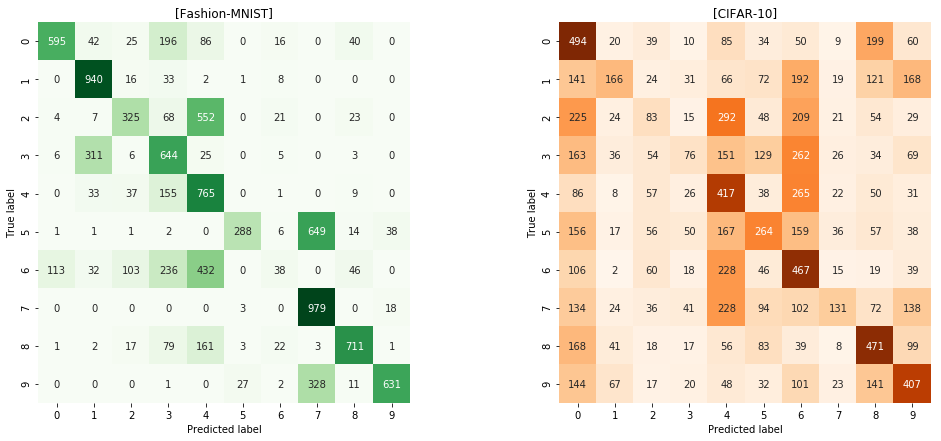

In [21]:
# PLOT THE CONFUSION MATRICES
plotConfusionMatrix(mnistCM, cifarCM, mnistClasses, cifarClasses)

<div class='alert alert-info'>
<div class='label label-danger'>QUESTION</div><br>
<b><i>f) Discuss the performance, compare them against a classifier that outputs
random class labels, and suggest ways in which performance could be improved.<br></i></b>
<br>
<div class='label label-danger'>ANSWER</div><br>
The performance are "good", considering that our models are very very simple. What is clear is that the performances on the <tt>Fashion-MNIST</tt> are way better than the <tt>CIFAR-10</tt> dataset. One of the things that cause the model to work badly are of course the dimensionality of the <tt>CIFAR-10</tt> dataset.<br>
As said before, we can apply LDA or try to reduce the dimensionality (especially for the <tt>CIFAR-10</tt> dataset) to facilitate the models life.<br>
<br>
The accuracies are:<br>
- [CLASSIFICATION] <tt>Fashion-MNIST</tt> accuracy: <b>59.16%</b><br>
- [CLASSIFICATION] <tt>CIFAR-10</tt> accuracy: <b>29.76%</b><br>
</div>

Let's see what happens for a <b>Random</b> classifier:

In [22]:
# RANDOM PREDICTIONS
mnistRandPred = np.random.randint(0, 9, mnistTest.shape[0])
cifarRandPred = np.random.randint(0, 9, cifarTest.shape[0])

# ACCURACY
mnistRandAcc = np.mean(mnistRandPred == mnistCorrect)
cifarRandAcc = np.mean(cifarRandPred == cifarCorrect)

# SHOW
print("[RANDOM Classifier] Fashion-MNIST random accuracy: %.2f%%" % (mnistRandAcc * 100))
print("[RANDOM Classifier] CIFAR-10 random accuracy:      %.2f%%" % (cifarRandAcc * 100))

[RANDOM Classifier] Fashion-MNIST random accuracy: 9.84%
[RANDOM Classifier] CIFAR-10 random accuracy:      9.78%


<div class='alert alert-info'>
The <b>random</b> classifier, of course, has an accuracy around 10%: the probability of getting the right class is $\frac{right \space class}{all \space classes}$, in this case: $\frac{1}{10}$.
</div>

# 4. Bayesian Regression

<div class='alert alert-info'>
<div class='label label-info'>TASK</div><br>
<b><i>a) Implement the Bayesian Linear Regression.<br></i></b>
</div>

In [23]:
class BayesianLinearRegression:
    
    # ----- PRIVATE METHODS ------------------------------------------------- #
    # CREATE THE MATRIX FOR THE MATRICIAL-FORM REGRESSION
    def _matricize(self, x, k):
        
        # ALLOCATE MATRIX
        X = np.ones(shape=(x.shape[0], 1), dtype=int)

        # STACK COLUMNS
        for i in range(k):
            X = np.hstack((X, np.power(x, i+1))) 
            
        return X
    
    
    # COMPUTE THE WEIGHTS ARRAY
    def _weights(self, X, t):
        
        # np.linalg.solve, when feasible, is faster so:
        #     inv(X.T.dot(X)).dot(X.T).dot(t)
        # becomes:
        return solve(X.T.dot(X), X.T.dot(t))
    
    
    # RETURN THE VARIANCE
    def _variance(self, X, w, t):
        
        return (t - X.dot(w.T)).T.dot(t - X.dot(w.T)) / X.shape[0]
    
    
    # RETURN THE PREDICTED t
    def _target(self, X_new, w):
        
        return X_new.dot(w.T)
    
    
    # RETURN THE PREDICTIVE VARIANCE
    def _predictiveVar(self, X_new, X, var):
        
        # ("+" instead of "*" for numerical reasons)
        return var + np.diag(X_new.dot(inv(X.T.dot(X))).dot(X_new.T))
    # ----------------------------------------------------------------------- #
    
    
    # ----- PUBLIC METHODS -------------------------------------------------- #
    # TRAIN
    def fit(self, train, target, k):
        
        # Compute X, w and t
        self.X = self._matricize(train, k)
        self.w = self._weights(self.X, target)
        self.var = self._variance(self.X, self.w, target)
        
        return np.unique(target)
    
    
    # TEST
    def predict(self, test, k):
        
        # Compute the matrix for the test set
        X_new = self._matricize(test, k)
        
        # Predict the new target for the test set (as a continuous variable)
        t_new_raw = self._target(X_new, self.w)
        
        # Compute the predictive variance
        var_new = self._predictiveVar(X_new, self.X, self.var)
        
        return t_new_raw, var_new
        
    
    # VALIDATION
    def validate(self, correct, raw):
        
        # Accuracy, error, confusion matrix, mse
        mse = mean_squared_error(correct, raw)
        
        return mse
    # ----------------------------------------------------------------------- #

<div class='alert alert-info'>
<div class='label label-info'>TASK</div><br>
<b><i>b) Treat class labels as continuous and apply regression to the training data.<br></i></b>
</div>

In [29]:
def regress(train, target, test, correct, k):
    
    # BAYESIAN LINEAR REGRESSION
    blr = BayesianLinearRegression()

    # TRAIN
    startTime = time()
    classes = blr.fit(train, target, k)
    endTime = time()
    print("Train time: %.3f seconds" % (endTime-startTime))

    # TEST
    startTime = time()
    raw, var = blr.predict(test, k)
    endTime = time()
    print("Test time:  %.3f seconds\n" % (endTime-startTime))

    # VALIDATION
    mse = blr.validate(correct, raw)
    print("[RAW PREDICTIONS] Mean Squared Error (MSE): %.2f" % (mse))
    
    return raw, var


def validatePictures(mnistRaw, mnistVar, cifarRaw, cifarVar):
    
    # SCATTER PLOT
    plotScatterPlot(mnistRaw, cifarRaw, mnistCorrect, cifarCorrect)
    
    # ERRORPLOT
    plotErrorPlot(mnistRaw, cifarRaw, mnistVar, cifarVar)

### <div class="label label-success">FASHION-MNIST</div>

In [25]:
# REGRESS
mnistRaw, mnistVar = regress(mnistTrain, mnistTarget, mnistTest, mnistCorrect, k = 1)

Train time: 1.396 seconds
Test time:  4.113 seconds

[RAW PREDICTIONS] Mean Squared Error (MSE): 1.96


### <div class="label label-warning">CIFAR-10</div>

In [26]:
# REGRESS
cifarRaw, cifarVar = regress(cifarTrain, cifarTarget, cifarTest, cifarCorrect, k = 1)

Train time: 12.154 seconds
Test time:  24.417 seconds

[RAW PREDICTIONS] Mean Squared Error (MSE): 8.03


<div class='alert alert-info'>
<div class='label label-info'>TASK</div><br>
<b><i>c) Produce a scatter plot showing the predictions versus the true targets for the
test set and compute the mean squared error on the test set.<br></i></b>
<br>
The mean squared error has been shown before, is:<br>
- [<tt>Fashion-MNIST</tt>] Mean Squared Error (MSE): <b>1.96</b><br>
- [<tt>CIFAR-10</tt>] Mean Squared Error (MSE): <b>8.03</b><br>
</div>

### <div class="label label-success">FASHION-MNIST</div> <div class="label label-warning">CIFAR-10</div>

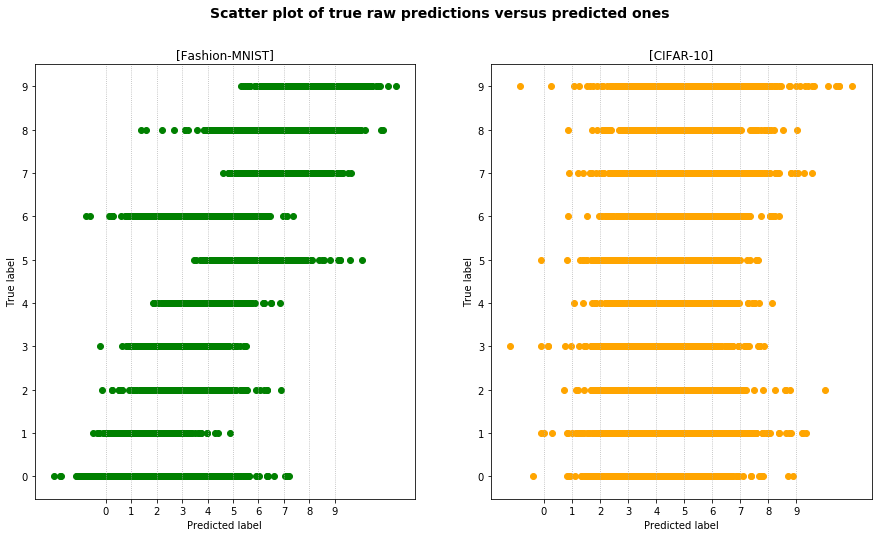

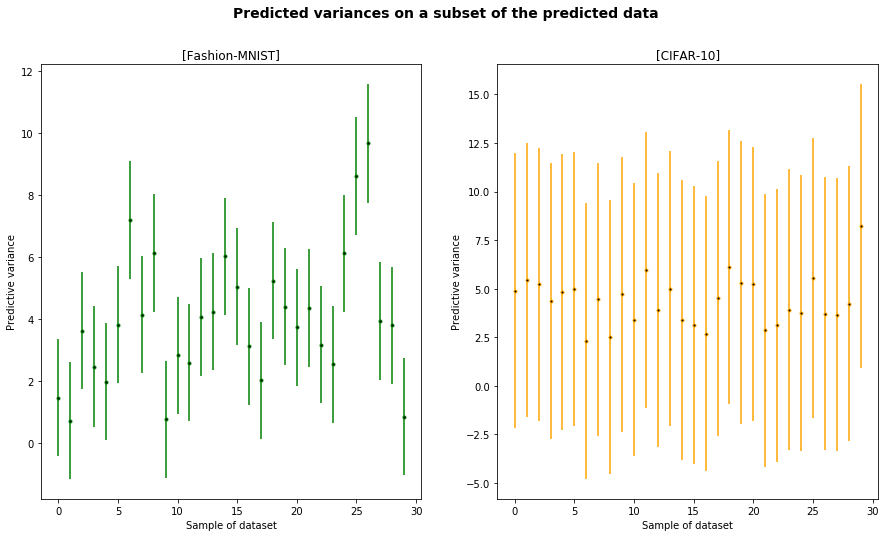

In [30]:
# PLOT IMAGES
validatePictures(mnistRaw, mnistVar, cifarRaw, cifarVar)

<div class='alert alert-info'>
<div class='label label-danger'>QUESTION</div><br>
<b><i>d) Suggest a way to discretize predictions and display the confusion matrix on the
test data and report accuracy.<br></i></b>
</div>

In [31]:
# DISCRETIZER
discretizer = np.vectorize(lambda label: 9 if label > 9 else (0 if label < 0 else round(label)))

### <div class="label label-success">FASHION-MNIST</div>

In [32]:
# DISCRETIZE
mnistPred = np.array(discretizer(mnistRaw), dtype=int)

# VALIDATE
accuracy = np.mean(mnistPred == mnistCorrect)
mnistCM = confusion_matrix(mnistCorrect, mnistPred)

print("[DISCRETE PREDICTIONS] Accuracy: %.2f%%" % (accuracy * 100))

[DISCRETE PREDICTIONS] Accuracy: 39.19%


### <div class="label label-warning">CIFAR-10</div>

In [33]:
# DISCRETIZE
cifarPred = np.array(discretizer(cifarRaw), dtype=int)

# VALIDATE
accuracy = np.mean(cifarPred == cifarCorrect)
cifarCM = confusion_matrix(cifarCorrect, cifarPred)

print("[DISCRETE PREDICTIONS] Accuracy: %.2f%%" % (accuracy * 100))

[DISCRETE PREDICTIONS] Accuracy: 10.95%


<div class='alert alert-info'>
<div class='label label-danger'>ANSWER</div><br>
The predictions have been discretized in a really simple way: the continuous variables have been rounded to the closest integer. Moreover, the values smaller than 0 have been approximated to 0, and the values bigger than 9 have been approximated to 9:
<code>
    discretizer = np.vectorize(lambda label: 9 if label > 9 else (0 if label < 0 else round(label)))
    t_new = np.array(discretizer(t_new_raw), dtype=int)
    
</code>
More advanced approaches could have been taken, like <b>one-hot encode</b> the labels and regress on each "column" of the one-hot encoded classes: this approch will be done after, in the final parts of the notebook.<br>
<br>
The regressor performances are:<br>
- [REGRESSION] <tt>Fashion-MNIST</tt> accuracy: <b>39.19%</b><br>
- [REGRESSION] <tt>CIFAR-10</tt> accuracy: <b>10.95%</b>
</div>

### <div class="label label-success">FASHION-MNIST</div> <div class="label label-warning">CIFAR-10</div>

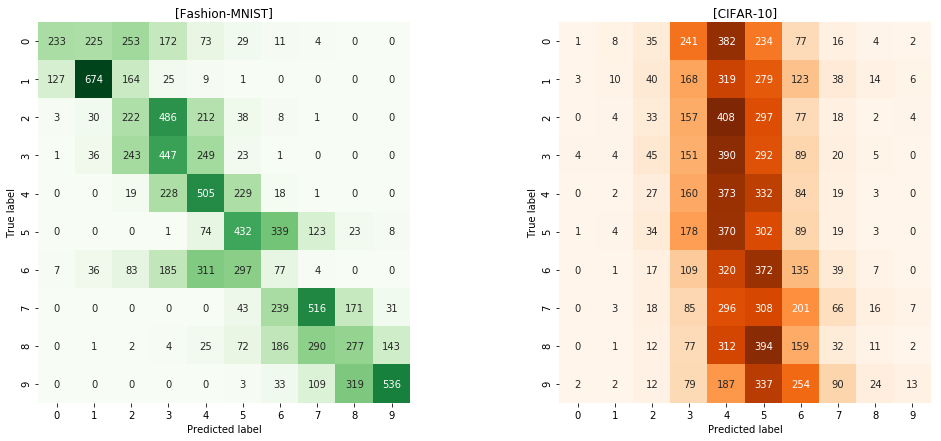

In [34]:
# CONFUSION MATRIX
plotConfusionMatrix(mnistCM, cifarCM, mnistClasses, cifarClasses)

<div class='alert alert-info'>
<div class='label label-danger'>QUESTION</div><br>
<b><i>e)  Discuss regression performance with respect to classification performance.<br></i></b>
<br>
<div class='label label-danger'>ANSWER</div><br>
The regression performances are of course very weak with respect to classification performance. A linear regression is a "wrong" tool to approach image classification problems.</i><br>
<br>
Also from the point of view of the computational time, in both datasets the Bayesian Regression is way slower than the Naive Bayes Classifier.
</div>

<div class='alert alert-info'>
<div class='label label-danger'>QUESTION</div><br>
<b><i>f) Describe one limitation of using regression for this particular task.<br></i></b>
<br>
<div class='label label-danger'>ANSWER</div><br>
One big limitation of linear regression is that it works trying to find a set of weights that models the relationships between the continuous data and the labels. In this case, even if it "works", is totally out of context: we're trying to find a set of discrete labels (from 0 to 9) according to some pre-defined pattern. Like said before: we're using a <i>"little drill against a huge building in reinforced concrete"</i>.<br>
<br>
It would have been a little bit more meaningful, if the [0,9] range would have had an "ordinal" information (like a gradual scale of values, where 0 < 1, 1 < 2, etc.): in that case, even if not the appropriate tool, it would have been more appropriate. But in this case, the labels are just "nominal" values where, for example, 2 means <b>different</b> than 1, and non greater than 1.
</div>

### Trying a different approach: one-hot encoded labels

<div class='alert alert-info'>
One approach to improve the Bayesian Linear Regression performance can be to <b>one-hot encode</b> the targets and regress on them one by one. In this case, the target column becomes a 10-column matrix, and a loop can be done on each column, using as target one at a time: the result will be a prediction matrix (10000, 10) and thanks to the argmax the best class will be chosen.<br>
<br>
Let's try it:
</div>

In [29]:
from keras.utils import to_categorical

def regressOneHot(train, target, test, correct, k):
    
    # BAYESIAN LINEAR REGRESSION
    blr = BayesianLinearRegression()

    # FIT & PREDICT
    target_bin = to_categorical(target, len(mnistClasses))
    pred = np.zeros((test.shape[0], len(mnistClasses)))
    for i in range(10):
        blr.fit(train, target_bin[:,i], k)
        _, _, pred[:,i] = blr.predict(test, k)
    pred = np.argmax(pred, axis=1)
    
    # VALIDATION
    accuracy = np.mean(pred == correct)
    cm = confusion_matrix(correct, pred)
    print("[DISCRETE PREDICTIONS] Accuracy: %.2f%%" % (accuracy * 100))
    
    return cm

Using TensorFlow backend.


### <div class="label label-success">FASHION-MNIST</div>

In [30]:
mnistCM = regressOneHot(mnistTrain, mnistTarget, mnistTest, mnistCorrect, 1)

[DISCRETE PREDICTIONS] Accuracy: 82.18%


### <div class="label label-warning">CIFAR-10</div>

In [31]:
cifarCM = regressOneHot(cifarTrain, cifarTarget, cifarTest, cifarCorrect, 1)

[DISCRETE PREDICTIONS] Accuracy: 36.37%


### <div class="label label-success">FASHION-MNIST</div> <div class="label label-warning">CIFAR-10</div>

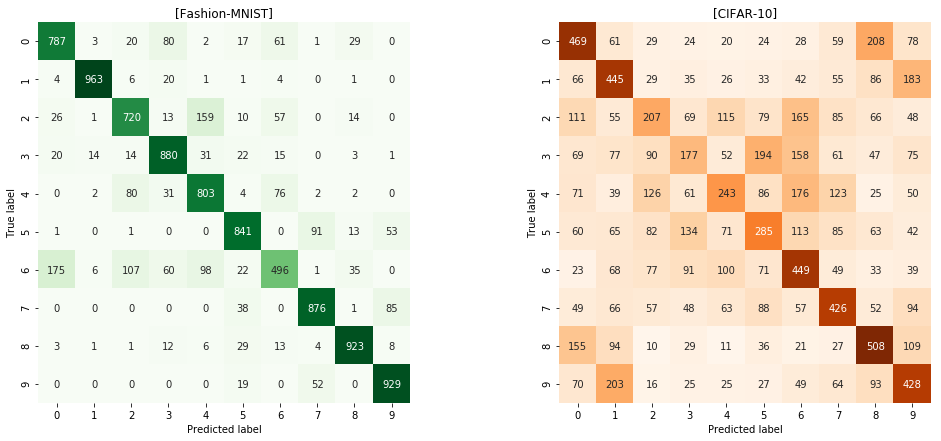

In [32]:
# CONFUSION MATRIX
plotConfusionMatrix(mnistCM, cifarCM, mnistClasses, cifarClasses)

<div class='alert alert-info'>
The results are <b>way better</b>! The accuracies now are:<br>
- [<tt>Fashion-MNIST</tt>] Accuracy: <b>82.18%</b> (before was 29%)<br>
- [<tt>CIFAR-10</tt>]  Accuracy: <b>36.37%</b> (before was 11%)<br>
<br>
The one-hot encoding, so, actually worked.
</div>

# 5. Bonus question
### Integrating Convolutional Neural Networks (with the <tt>LeNet</tt> architecture) and the Naive Bayes Classifier

<div class='alert alert-info'>
Convolutional Neural Networks actually represent one of the most powerful methods to face image classification problems (<a href="https://en.wikipedia.org/wiki/Convolutional_neural_network">source</a>).<br>
<br>
The simplest architecture is the <tt>LeNet</tt> (<a href="http://yann.lecun.com/exdb/lenet/">source</a>): two convolution layers alternated by the max pooling phase, followed by a flatten phase and a set of fully connected layers.
<img src="https://raw.githubusercontent.com/udacity/CarND-LeNet-Lab/master/lenet.png" width="800px">
<br>
Let's implement the model using Keras:
</div>

In [21]:
%%capture

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

In [22]:
class LeNetCNN:
    
    def reshape(self, train, target, test, correct, num_classes, input_shape):
        
        # DESIRED INPUT SHAPE
        h, w, c = self.input_shape = input_shape
        self.num_classes = num_classes
        
        # RESHAPE
        # Train set
        self.train = train.reshape((train.shape[0], h, w, c)).astype('float32')
        self.target_bin = to_categorical(target, num_classes)

        # Test set
        self.test = test.reshape((test.shape[0], h, w, c)).astype('float32')
        self.correct_bin = to_categorical(correct, num_classes)
        
        return self.train, self.test
        
        
    def buildAndRun(self, batch_size, epochs):
        
        # MODEL CONSTRUCTION (LeNet architecture)
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', name="intermediate"))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes, activation='softmax'))

        # MODEL COMPILING
        model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=['accuracy'])
        
        # TRAIN
        model.fit(self.train,
                  self.target_bin,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_split=0.1)

        # PREDICT
        score = model.evaluate(self.test, self.correct_bin, verbose=0)
        print("\nConvolutional Neural Network:")
        print(' - Loss: %.2f' % (score[0]))
        print(' - Accuracy: %.2f%%' % (score[1]*100))
    
        return model

<div class='alert alert-info'>
Now let's run the model with our two dataset:
</div>

### <div class="label label-success">FASHION-MNIST</div>

In [23]:
# BUILD, RESHAPE THE DATASETS AND RUN THE CNN
cnn = LeNetCNN()

train, test = cnn.reshape(mnistTrain, mnistTarget, mnistTest, mnistCorrect,
                          num_classes = 10, input_shape = (28,28,1))

model = cnn.buildAndRun(batch_size = 128, epochs = 7)

Train on 54000 samples, validate on 6000 samples
Epoch 1/7
54000/54000 [==============================] - 60s 1ms/step - loss: 0.7067 - acc: 0.7409 - val_loss: 0.4464 - val_acc: 0.8387
Epoch 2/7
54000/54000 [==============================] - 58s 1ms/step - loss: 0.4572 - acc: 0.8357 - val_loss: 0.3779 - val_acc: 0.8638
Epoch 3/7
54000/54000 [==============================] - 59s 1ms/step - loss: 0.4021 - acc: 0.8574 - val_loss: 0.3412 - val_acc: 0.8758
Epoch 4/7
54000/54000 [==============================] - 59s 1ms/step - loss: 0.3679 - acc: 0.8674 - val_loss: 0.3168 - val_acc: 0.8830
Epoch 5/7
54000/54000 [==============================] - 59s 1ms/step - loss: 0.3433 - acc: 0.8760 - val_loss: 0.2961 - val_acc: 0.8932
Epoch 6/7
54000/54000 [==============================] - 59s 1ms/step - loss: 0.3226 - acc: 0.8834 - val_loss: 0.2999 - val_acc: 0.8872
Epoch 7/7
54000/54000 [==============================] - 59s 1ms/step - loss: 0.3107 - acc: 0.8887 - val_loss: 0.2807 - val_acc: 0.8965

<div class='alert alert-success'>
The accuracy of the output of the neural network is not bad at all. However, we're not interested in it, but in using the intermediate model built after the two <i>"Convolution -> ReLU activation -> Pooling"</i> phases, right after the outputs are flattened.<br>
<br>
Now the <tt>intermediate_model</tt> will be used to generate the intermediate trainset and testset which will be given as input to the Naive Bayes Classifier.
</div>

In [24]:
# EXTRACT THE MODEL OF THE INTERMEDIATE LAYER
model_intermediate = Model(inputs=model.input, outputs=model.get_layer("intermediate").output)

# PREDICT TO GET THE INTERMEDIATE TRAINSET AND TESTSET
train_intermediate = model_intermediate.predict(train)
test_intermediate = model_intermediate.predict(test)

# CLASSIFY MNIST
mnistCM = classify(train = train_intermediate,
                  target = mnistTarget,
                  test = test_intermediate,
                  correct = mnistCorrect)

Train time: 0.186 seconds
Test time:  0.153 seconds

Accuracy: 89.58%
LogLikelihood Loss: 1.29


### <div class="label label-warning">CIFAR-10</div>

In [25]:
# BUILD, RESHAPE THE DATASETS AND RUN THE CNN
cnn = LeNetCNN()

train, test = cnn.reshape(cifarTrain, cifarTarget, cifarTest, cifarCorrect,
                          num_classes = 10, input_shape = (32,32,3))

model = cnn.buildAndRun(batch_size = 128, epochs = 7)

Train on 45000 samples, validate on 5000 samples
Epoch 1/7
45000/45000 [==============================] - 78s 2ms/step - loss: 1.9172 - acc: 0.3047 - val_loss: 1.5912 - val_acc: 0.4390
Epoch 2/7
45000/45000 [==============================] - 77s 2ms/step - loss: 1.5771 - acc: 0.4409 - val_loss: 1.3916 - val_acc: 0.5014
Epoch 3/7
45000/45000 [==============================] - 78s 2ms/step - loss: 1.4448 - acc: 0.4892 - val_loss: 1.3789 - val_acc: 0.5264
Epoch 4/7
45000/45000 [==============================] - 83s 2ms/step - loss: 1.3628 - acc: 0.5186 - val_loss: 1.2538 - val_acc: 0.5518
Epoch 5/7
45000/45000 [==============================] - 84s 2ms/step - loss: 1.3029 - acc: 0.5414 - val_loss: 1.1956 - val_acc: 0.5724
Epoch 6/7
45000/45000 [==============================] - 88s 2ms/step - loss: 1.2496 - acc: 0.5609 - val_loss: 1.1591 - val_acc: 0.5950
Epoch 7/7
45000/45000 [==============================] - 85s 2ms/step - loss: 1.2067 - acc: 0.5797 - val_loss: 1.1647 - val_acc: 0.5826

<div class='alert alert-warning'>
Also in the <tt>CIFAR-10</tt> case (like in the <tt>Fashion-MNIST</tt>) the accuracy of the output of the neural network is better than the one provided by the pure Naive Bayes Classifier. However, like said before, the interest in not in the network output but in the intermediate model built after the two <i>"Convolution -> ReLU activation -> Pooling"</i> phases, right after the outputs are flattened.<br>
<br>
Now the <tt>intermediate_model</tt> will be used to generate the intermediate trainset and testset which will be given as input to the Naive Bayes Classifier.
</div>

In [26]:
# EXTRACT THE MODEL OF THE INTERMEDIATE LAYER
model_intermediate = Model(inputs=model.input, outputs=model.get_layer("intermediate").output)

# PREDICT TO GET THE INTERMEDIATE TRAINSET AND TESTSET
train_intermediate = model_intermediate.predict(train)
test_intermediate = model_intermediate.predict(test)

# CLASSIFY CIFAR
cifarCM = classify(train = train_intermediate,
          target = cifarTarget,
          test = test_intermediate,
          correct = cifarCorrect)

Train time: 0.164 seconds
Test time:  0.154 seconds

Accuracy: 59.25%
LogLikelihood Loss: 3.26


### <div class="label label-success">FASHION-MNIST</div> <div class="label label-warning">CIFAR-10</div>

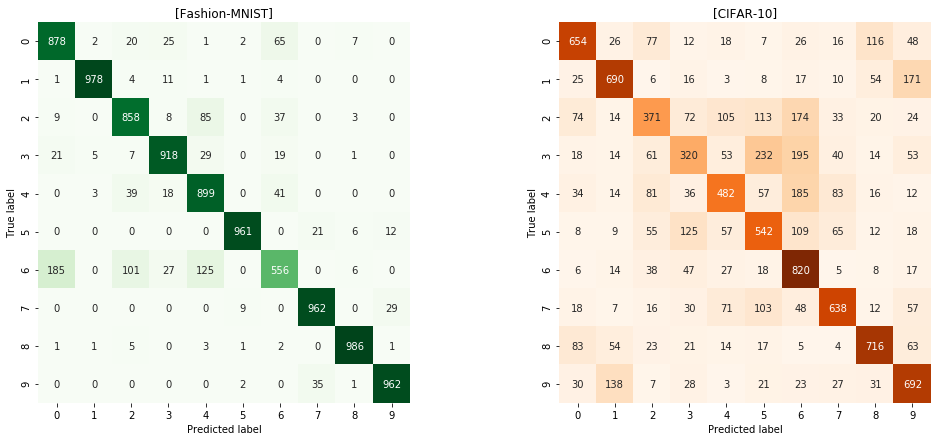

In [27]:
# PLOT THE CONFUSION MATRICES
plotConfusionMatrix(mnistCM, cifarCM, mnistClasses, cifarClasses)

<div class='alert alert-info'>
The performance are <b>way better</b>!<br>
<br>
We obtain the <b>89.58%</b> of accuracy with the <tt>Fashion-MNIST</tt> dataset, and <b>59.25%</b> of accuracy with the <tt>CIFAR-10</tt>.<br>
<br>
This means that also very simple models, like the Naive Bayes Classifier, can be <b>hugely</b> helped by anticipating powerful models like CNNs!
</div>